In [ ]:
import os
import zipfile
import pandas as pd
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, inception_v3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Setup Kaggle
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
os.makedirs(kaggle_dir, exist_ok=True)

# Upload Kaggle JSON
if not os.path.exists(kaggle_json_path):
   print("Upload your kaggle.json file.")
   files.upload()
   os.system('cp kaggle.json ~/.kaggle/')
   os.system('chmod 600 ~/.kaggle/kaggle.json')

# Download and Extract Dataset
zip_file_path = '100-bird-species.zip'
if not os.path.exists(zip_file_path):
   os.system('kaggle datasets download -d gpiosenka/100-bird-species')
   with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()

Upload your kaggle.json file.


Saving kaggle.json to kaggle.json


In [ ]:
# Load and Preprocess Data
birds_csv_path = 'birds.csv'
if os.path.exists(birds_csv_path):
   birds_df = pd.read_csv(birds_csv_path)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('AKULET', 'AUKLET', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/5.jpg', 'valid/PARAKETT AUKLET/5.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/4.jpg', 'valid/PARAKETT AUKLET/4.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/3.jpg', 'valid/PARAKETT AUKLET/3.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/2.jpg', 'valid/PARAKETT AUKLET/2.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/1.jpg', 'valid/PARAKETT AUKLET/1.jpg', regex=False)
   birds_df['labels'] = birds_df['labels'].str.replace('AKULET', 'AUKLET', regex=False)
else:
   print("Dataset not found.")

In [ ]:
# Find the paths of invalid files
invalid_filepaths = [filepath for filepath in birds_df['filepaths'] if not os.path.isfile(filepath)]

# Print the paths of invalid files
print("Invalid files found:", len(invalid_filepaths))
if len(invalid_filepaths) > 0:
    print("Examples of invalid paths:", invalid_filepaths)

Invalid files found: 0


In [ ]:
# Filter to split the datasets
train_df = birds_df[birds_df['data set'] == 'train'].reset_index(drop=True)
test_df = birds_df[birds_df['data set'] == 'test'].reset_index(drop=True)
valid_df = birds_df[birds_df['data set'] == 'valid'].reset_index(drop=True)

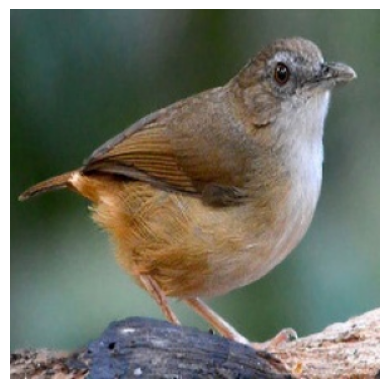

In [ ]:
def load_and_preprocess_image(image_path, target_size=(299, 299)):
      try:
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        image = image.resize(target_size)
        image_array = np.array(image)
          # Preprocess for model input
        preprocessed_image = preprocess_input(image_array)
        return preprocessed_image, image
      except IOError:
        return None, None



sample_image_path = 'train/ABBOTTS BABBLER/042.jpg'
_, original_image = load_and_preprocess_image(sample_image_path)

# Display the original image
if original_image is not None:
    plt.imshow(original_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()
else:
    print("Image could not be loaded.")


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='max')
model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
def extract_features_batch(image_paths, model, batch_size=32):
      batch_features = []
      total_images = len(image_paths)
      for batch_start in range(0, total_images, batch_size):
          batch_imgs = [load_and_preprocess_image(img_path)[0] for img_path in image_paths[batch_start:batch_start + batch_size]]
          batch_imgs = [img for img in batch_imgs if img is not None]  # Filter out None

          # Ensure the images are correctly shaped
          if batch_imgs and batch_imgs[0].ndim == 3:
             batch_imgs = np.stack(batch_imgs, axis=0)
             features = model.predict(batch_imgs)
             batch_features.extend(features.reshape((features.shape[0], -1)))
          else:
             print("Skipped a batch due to incorrect image dimensions")
      return batch_features


In [ ]:
# Process images in batches
batch_size = 32
total_images = len(train_df['filepaths'])
print(f"Total images to process: {total_images}")
features_list = []

for batch_start in range(0, total_images, batch_size):
    batch_paths = train_df['filepaths'][batch_start:batch_start + batch_size].tolist()
    batch_features = extract_features_batch(batch_paths, model, batch_size)
    features_list.extend(batch_features)

    # Progress update
    processed_images = min(batch_start + batch_size, total_images)
    print(f"Processed batch {processed_images // batch_size}/{-(-total_images // batch_size)} ({processed_images}/{total_images})")

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 54ms/step
Processed batch 146/2645 (4672/84635)
1/1 [==============================] - 0s 53ms/step
Processed batch 147/2645 (4704/84635)
1/1 [==============================] - 0s 76ms/step
Processed batch 148/2645 (4736/84635)
1/1 [==============================] - 0s 74ms/step
Processed batch 149/2645 (4768/84635)
1/1 [==============================] - 0s 74ms/step
Processed batch 150/2645 (4800/84635)
1/1 [==============================] - 0s 71ms/step
Processed batch 151/2645 (4832/84635)
1/1 [==============================] - 0s 76ms/step
Processed batch 152/2645 (4864/84635)
1/1 [==============================] - 0s 69ms/step
Processed batch 153/2645 (4896/84635)
1/1 [==============================] - 0s 76ms/step
Processed batch 154/2645 (4928/84635)
1/1 [==============================] - 0s 72ms/step
Processed batch 155/2645 (4960/84635)
1/1 [==============================] - 0s 85ms/ste

In [ ]:
features_list = np.array(features_list)

def find_similar_images_cosine(query_idx, features, top_n=5):
    query_feature = features[query_idx].reshape(1, -1)
    similarity_scores = cosine_similarity(query_feature, features)[0]
    similarity_scores[query_idx] = -1  # Exclude the query image from the results

    top_indices = np.argsort(similarity_scores)[::-1][:top_n]
    return top_indices, similarity_scores[top_indices]

# Example usage
query_image_idx = 100  # Index of the query image
similar_indices, similar_scores = find_similar_images_cosine(query_image_idx, features_list, top_n=5)

index_to_label = {index: label for index, label in enumerate(birds_df['labels'])}

# Retrieve the label for the query image
query_label = index_to_label[query_image_idx]

# Print the label of the query image
print(f"Query Image Label: {query_label}")

# Retrieve and print the labels and scores of similar images
for idx, score in zip(similar_indices, similar_scores):
    label = index_to_label[idx]  # Assuming 'index_to_label' mapping exists
    percentage_score = score * 100  # Convert score to percentage
    print(f"Label: {label}, Similarity Score: {percentage_score:.2f}%")


Query Image Label: ABBOTTS BABBLER
Label: ABBOTTS BABBLER, Similarity Score: 91.48%
Label: GREATER PEWEE, Similarity Score: 90.88%
Label: WOOD THRUSH, Similarity Score: 90.65%
Label: SCARLET FACED LIOCICHLA, Similarity Score: 90.55%
Label: JOCOTOCO ANTPITTA, Similarity Score: 90.48%


In [ ]:
def display_similar_images(indices, scores, labels, image_paths, query_idx, query_label, rows=2, cols=3):
    # Ensure the indices and image_paths are valid
    if indices is None or not image_paths or query_idx >= len(image_paths):
      print("Invalid input for displaying images.")
      return

    # Adjust the layout
    total_images = len(indices) + 1  # +1 for the query image
    cols = min(cols, total_images)
    rows = max(1, (total_images + cols - 1) // cols)  # Ceiling division for rows

    plt.figure(figsize=(cols * 4, rows * 4))

    # Display the query image with its label
    plt.subplot(rows, cols, 1)
    query_image = plt.imread(image_paths[query_idx])
    plt.imshow(query_image)
    plt.title(f"Query: {query_label}")
    plt.axis('off')

    # Display similar images with their labels and similarity scores
    for i, (index, score, label) in enumerate(zip(indices, scores, labels), start=2):
        try:
           similar_image = plt.imread(image_paths[index])
           plt.subplot(rows, cols, i)
           plt.imshow(similar_image)
           similarity_percentage = score * 100  # Convert score to percentage
           plt.title(f"{label}\nSimilarity: {similarity_percentage:.2f}%")
           plt.axis('off')
        except IOError:
           print(f"Error loading image at index {index}")

    plt.tight_layout()
    plt.show()

# Assuming 'find_similar_images_cosine' function is defined as before
query_image_idx = 100  # Example index for the query image
query_label = index_to_label[query_image_idx]  # Retrieve the label for the query image
image_paths = birds_df['filepaths'].tolist()

similar_images_indices, similar_images_scores = find_similar_images_cosine(query_image_idx, features_list, top_n=5)
similar_images_labels = [index_to_label[idx] for idx in similar_images_indices]

display_similar_images(similar_images_indices, similar_images_scores, similar_images_labels, image_paths, query_image_idx, query_label)


1/1 [==============================] - 0s 27ms/step


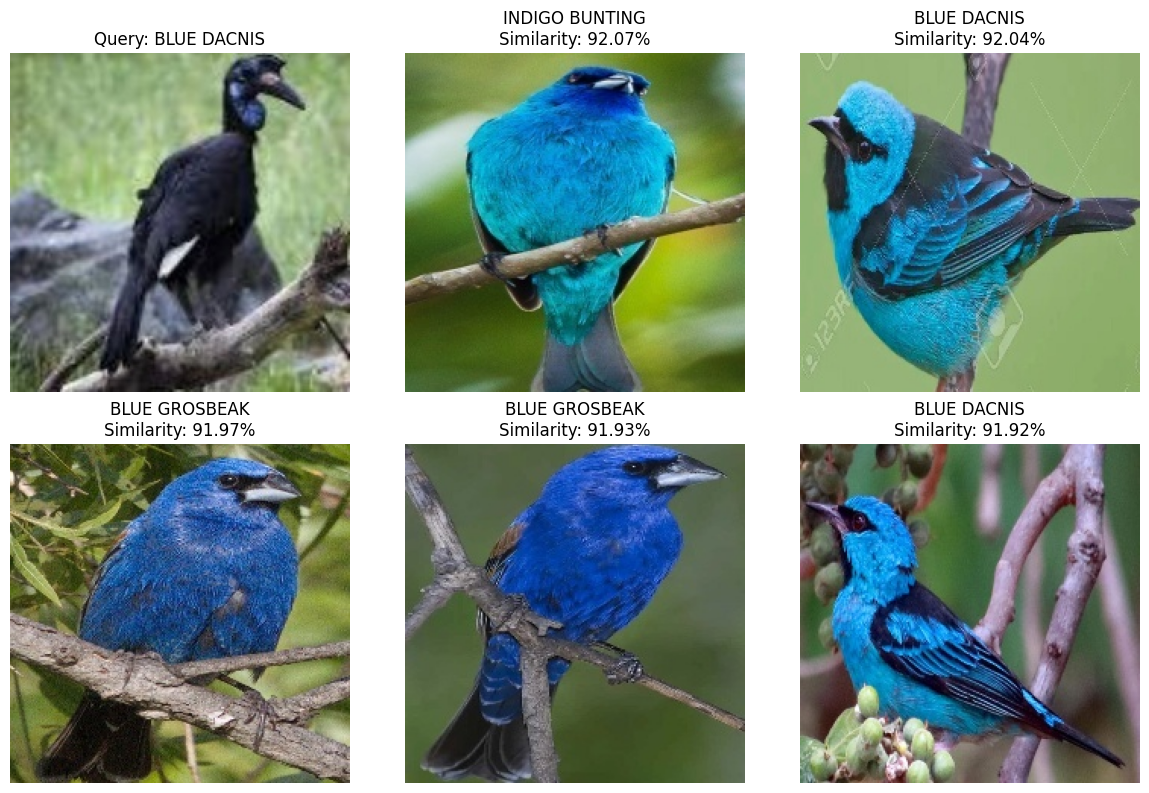

In [ ]:
def extract_features_single_image(image_path, model):
      try:
         image = Image.open(image_path).convert('RGB')
         image = image.resize((299, 299))
         image_array = np.array(image)
         image_array = preprocess_input(image_array)
         image_array = np.expand_dims(image_array, axis=0)
         features = model.predict(image_array)
         return features.reshape(1, -1)
      except IOError:
         print(f"Errore nel caricare l'immagine da {image_path}")
         return None


#Choose an index for the test image
test_image_idx = 470  # or any other valid index in your test_df

# Extract the path and label of the test image
test_image_path = test_df['filepaths'].iloc[test_image_idx]
test_label = test_df['labels'].iloc[test_image_idx]

# Extract the features of the test image
test_features = extract_features_single_image(test_image_path, model)

# Ensure that test_features is not None
if test_features is not None:
    # Combine the test image features with the training features
    combined_features = np.vstack([features_list, test_features])

    # Compute similarity with all images (training + test)
    similar_indices, similar_scores = find_similar_images_cosine(-1, combined_features, top_n=6)  # Use -1 for the index of the test image

    # Filter out the test image index from the results, if included
    similar_indices = [idx for idx in similar_indices if idx != combined_features.shape[0] - 1]

    # Retrieve labels for the top 5 similar images
    similar_images_labels = [index_to_label[idx] for idx in similar_indices[:5]]

    # Display the results
    display_similar_images(similar_indices[:5], similar_scores[:5], similar_images_labels, image_paths, test_image_idx, test_label)
else:
    print("Unable to extract features for the test image.")



In [ ]:
def get_img_array(img_path, size):
    img = keras_image.load_img(img_path, target_size=size)
    array = keras_image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
         last_conv_layer_output, preds = grad_model(img_array)
         if pred_index is None:
            pred_index = tf.argmax(preds[0])
         class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.7):
      # Load the original image
      img = keras_image.load_img(img_path)
      img = keras_image.img_to_array(img)

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras_image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras_image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on the original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras_image.array_to_img(superimposed_img)

      return keras_image.array_to_img(superimposed_img)


# Assuming similar_image_paths is a list of file paths for the top 5 similar images
img_size = (299, 299)  # Size for InceptionV3
last_conv_layer_name = 'mixed10'  # Last conv layer in InceptionV3

# Choose a query image from train_df
query_idx = 12  # For example, the 7th image in train_df
query_image_path = train_df['filepaths'].iloc[query_idx]
query_label = train_df['labels'].iloc[query_idx]

# Extract features of the query image
query_features = extract_features_single_image(query_image_path, model)

# Find similar images (assuming features_list contains features of all training images)
similar_indices, similar_scores = find_similar_images_cosine(query_idx, features_list, top_n=5)

# Total number of images to display (query image + similar images)
total_images = 1 + len(similar_indices)

# Calculate the number of rows needed to organize the images in three columns
num_rows = total_images // 3 + int(total_images % 3 > 0)

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows * 5))
title_fontsize = 22
# Display the query image first
axes[0, 0].imshow(keras_image.load_img(query_image_path))
axes[0, 0].axis('off')

# Display similar images with Grad-CAM
for i, (idx, similarity_percentage) in enumerate(zip(similar_indices, similar_scores)):
    row, col = (i + 1) // 3, (i + 1) % 3

    similar_img_path = train_df['filepaths'][idx]
    similar_label = train_df['labels'][idx]

    img_array = preprocess_input(get_img_array(similar_img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    superimposed_img = save_and_display_gradcam(similar_img_path, heatmap)

    axes[row, col].imshow(superimposed_img)
    axes[row, col].axis('off')

# Hide any empty axes if the total number of images is not a multiple of 3
for ax in axes.flat[total_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 28ms/step


In [ ]:
# Process images in batches
# batch_size = 32
# total_images_demo = len(birds_df['filepaths'])
# print(f"Total images to process: {total_images_demo}")
# features_list_demo = []

# for batch_start in range(0, total_images_demo, batch_size):
#     batch_paths = birds_df['filepaths'][batch_start:batch_start + batch_size].tolist()
#     batch_features = extract_features_batch(batch_paths, model, batch_size)
#     features_list_demo.extend(batch_features)

    # Progress update
#     processed_images = min(batch_start + batch_size, total_images_demo)
#    print(f"Processed batch {processed_images // batch_size}/{-(-total_images_demo // batch_size)} ({processed_images}/{total_images_demo})")

In [ ]:
# path = '/content/drive/MyDrive/Magistrale/Progetto Digital Signal and Image Management/feature_list.pkl'

# with open(path, 'wb') as file:
#    pickle.dump(features_list_demo, file)

#    print("Feature list salvata su Google Drive.")
